In [1]:
#instruction to be able to zoom on matplotlib figure
%matplotlib widget 


import sys
sys.path.insert(0,'../source')
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
#from datetime import datetime

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# Import module for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, corr_data, copy_attr
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_corr_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa
from m_read_write_netcdf import corr_file

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_5615/1733548744.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#
# Init.
#

# WMO Float (string format)
num_float = '6902978'

cmp_ctd = 0 # 1 if comparison with CTD is used, 0 otherwise
num_cycle = 1 # Cycle to compare to CTD
rep_ctd = '/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/' #'/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/'
fic_ctd = 'rr17_PRES.nc' #'ovid18_PRES.nc' # Netcdf File with CTD

#rep_ctd = '/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/'
#fic_ctd = 'ovid18_PRES.nc' # Netcdf File with CTD
num_ctd = 40 # Station Number to compare

# ARGO directory : Directory where you can find 1 directory per WMO ARGO float.
# In the WMO float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
#rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'

# The WOA file containing the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# this file is created by an internal LOPS routine.
#
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'

# which variable to used :
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2

#
# Which PSAT to used :
# which_psat = 1 : We use PSAT from WOA file
# which_psat = 2 We use PSAT calculated as Locodox
which_psat = 2
# Min and Max pressure to average WOA and ARGO PPOX
min_pres_interp = 0
max_pres_interp = 25

# Which QC used for pressure, temperature, salinity and oxygen.
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

In [3]:
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/ref-argo/gdac/dac/coriolis/6902978/6902978_meta.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902978/6902978_Sprof.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902978/6902978_Rtraj.nc


In [4]:
ds_argo_Sprof['PLATFORM_NUMBER'].values[0]

6902978

In [5]:
if (num_float==str(6902978)):
    ds_argo_Sprof = ds_argo_Sprof.where(ds_argo_Sprof['CYCLE_NUMBER']<=106,drop=True)

In [7]:
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2020-07-14T09:22:00.000000000
-0.3


In [8]:
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


In [9]:
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [10]:
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 15.0 46.0 75.0 106.0 ... 259.0 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 ...
    longitude  (lon) float64 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 ...
    density    (time, N_LEVELS, lat, lon) float64 ...
    preswoa    (time, N_LEVELS, lat, lon) float64 ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 ...

In [11]:
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 -15.25 15.0 46.0 75.0 ... 289.0 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    density   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
101.865898

In [12]:
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]

# Interpolation WOA et ARGO sur une grille reguliere en pression.
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [13]:
ds_woa_interp

<xarray.Dataset>
Dimensions:   (N_PROF: 107, N_LEVELS: 26)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    doxywoa   (N_PROF, N_LEVELS) float64 251.0 251.6 252.3 ... 285.6 285.4 285.2
    Psatwoa   (N_PROF, N_LEVELS) float64 105.8 106.0 106.1 ... 104.3 104.2 104.1
    density   (N_PROF, N_LEVELS) float64 1.026e+03 1.026e+03 ... 1.027e+03
    preswoa   (N_PROF, N_LEVELS) float64 0.0 1.0 2.0 3.0 ... 22.0 23.0 24.0 25.0
    PSAL_WOA  (N_PROF, N_LEVELS) float64 34.9 34.9 34.9 ... 34.98 34.99 34.99
    TEMP_WOA  (N_PROF, N_LEVELS) float64 15.94 15.93 15.92 ... 10.06 10.05 10.04

In [14]:
ds_argo_interp

<xarray.Dataset>
Dimensions:       (N_PROF: 107, N_LEVELS: 26)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan ... 9.828 9.821 9.607
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan nan ... 3.8 5.0 6.6 7.0
    PSAL_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan ... 34.86 34.87 34.84
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan nan ... 3.8 5.0 6.6 7.0
    DOXY_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan ... 249.4 247.7 247.7
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan nan ... 1.714 2.4 2.571
    PRES_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan nan ... 23.0 24.0 25.0
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0

In [15]:
#for var in ds_argo_interp.data_vars :
#    ds_argo_interp[var].attrs = ds_argo[var].attrs    
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [16]:
ds_woa_interp

<xarray.Dataset>
Dimensions:   (N_PROF: 107, N_LEVELS: 26)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    doxywoa   (N_PROF, N_LEVELS) float64 251.0 251.6 252.3 ... 285.6 285.4 285.2
    Psatwoa   (N_PROF, N_LEVELS) float64 105.8 106.0 106.1 ... 104.3 104.2 104.1
    density   (N_PROF, N_LEVELS) float64 1.026e+03 1.026e+03 ... 1.027e+03
    preswoa   (N_PROF, N_LEVELS) float64 0.0 1.0 2.0 3.0 ... 22.0 23.0 24.0 25.0
    PSAL_WOA  (N_PROF, N_LEVELS) float64 34.9 34.9 34.9 ... 34.98 34.99 34.99
    TEMP_WOA  (N_PROF, N_LEVELS) float64 15.94 15.93 15.92 ... 10.06 10.05 10.04

In [17]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

We calculate PSAT as Locodox Matlab does


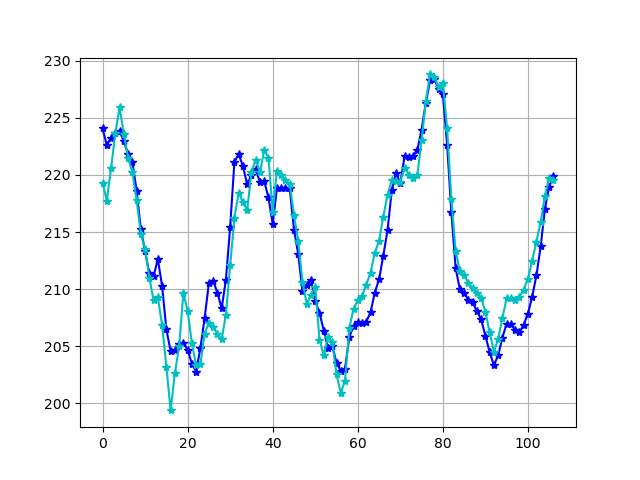

In [18]:
if which_psat == 2:
    print('We calculate PSAT as Locodox Matlab does')
    ana_dens_woa = sw.pden(ds_woa_interp['PSAL_WOA'],ds_woa_interp['TEMP_WOA'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
    O2_ARGO_umolL = umolkg_to_umolL(ds_woa_interp['doxywoa'],ds_argo['DOXY_ARGO'].units,ana_dens_woa)
    psatwoaV2 = O2ctoO2s(O2_ARGO_umolL,ds_woa_interp['TEMP_WOA'],ds_woa_interp['PSAL_WOA'])
    ppox_WOA2 = O2stoO2p(psatwoaV2,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
    ppox_WOA_mean2 = np.nanmean(ppox_WOA2,axis=1)

    plt.figure()
    plt.plot(ppox_WOA_mean,'*-b')
    plt.plot(ppox_WOA_mean2,'*-c')
    plt.grid()

    ppox_WOA_mean = ppox_WOA_mean2

In [19]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [20]:
# Correction : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
#params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
#print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')


In [21]:
# Correction : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
#params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean, p0=initial_guess,nan_policy='omit',full_output=True)
#print(params_Gain_Derive_WOA)

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)

In [22]:
print(params_Gain_Derive_WOA)

[1.06867661 2.2293753 ]


In [23]:
# NCEP Correction
# Download NCEP Data
download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)
#annee_to_download = [min(ds_argo['JULD'].dt.year).values,max(ds_argo['JULD'].dt.year).values]
#download_NCEP_force(annee_to_download,ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

File slp.2020.nc already exists with the same size. No Download
File air.sig995.2020.nc already exists with the same size. No Download
File rhum.sig995.2020.nc already exists with the same size. No Download
File slp.2021.nc already exists with the same size. No Download
File air.sig995.2021.nc already exists with the same size. No Download
File rhum.sig995.2021.nc already exists with the same size. No Download
File slp.2022.nc already exists with the same size. No Download
File air.sig995.2022.nc already exists with the same size. No Download
File rhum.sig995.2022.nc already exists with the same size. No Download
File slp.2023.nc already exists with the same size. No Download
File air.sig995.2023.nc already exists with the same size. No Download
File rhum.sig995.2023.nc already exists with the same size. No Download


We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


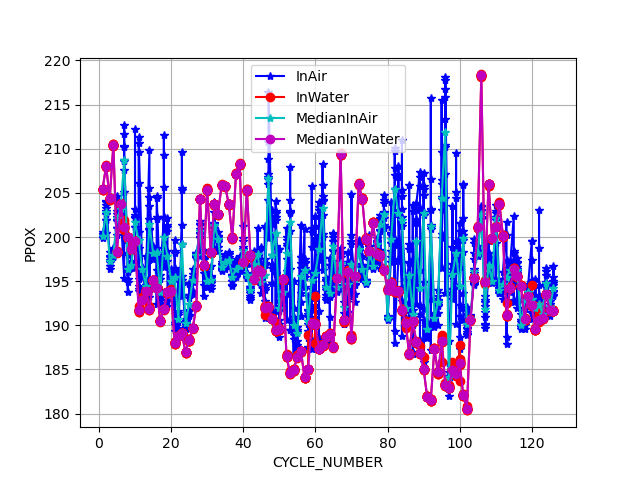

PSAL_ADJUSTED Data is used


IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)

In [ ]:
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])

z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [25]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

NameError: name 'dsair' is not defined

In [26]:
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

NameError: name 'dsair' is not defined

In [27]:
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

NameError: name 'PPOX1' is not defined

In [28]:
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)

NameError: name 'dsair' is not defined

In [29]:
print(params_Gain_WOA)
print(params_Gain_NCEP)
#print(params_Gain_NCEP_CarryOver[0])
print(params_Gain_Derive_WOA)
print(params_Gain_Derive_NCEP)
#print(params_Gain_Derive_NCEP_CarryOver[0],params_Gain_Derive_NCEP_CarryOver[2])
gain_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
gain_Derive_CarryOver = np.array([params_Gain_Derive_NCEP_CarryOver[0], params_Gain_Derive_NCEP_CarryOver[2]])
print(gain_CarryOver)
print(gain_Derive_CarryOver)

[1.10274706]


NameError: name 'params_Gain_NCEP' is not defined

In [30]:
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : gain_CarryOver,'Gain/Derive Ncep CarryOver' : gain_Derive_CarryOver}

_=plot_cmp_corr_NCEP(dict_corr,dsair,NCEP_PPOX,delta_T_NCEP)


NameError: name 'params_Gain_NCEP' is not defined

In [31]:
_=plot_cmp_corr_WOA(dict_corr, ds_argo_interp, ds_woa_interp, delta_T_WOA)

NameError: name 'dict_corr' is not defined

In [32]:
# Compare ARGO Profil  with  CTD 
if cmp_ctd==1:
    ds_cruise = xr.open_dataset(rep_ctd + fic_ctd)
    ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd,drop=True)
    ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
    _=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 

In [34]:
# Which corrrection to apply
params_to_keep = gain_Derive_CarryOver #params_Gain_Derive_NCEP
if ( (num_float == str(6902881)) | (num_float == str(6902686)) | (num_float == str(6902978)) ): 
    params_to_keep = params_Gain_Derive_WOA
    
print(params_to_keep)

if cmp_ctd==1:
# Comparison between CTD and ARGO float Cycle
    oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))


    delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
    tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))


# Correction for the cycle associated to the CTD
    cycle_corr = model_Gain_Derive([ds_cycle['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_to_keep)


    if num_float == str(6902881):
        print('pressure effect')
        pressure_threshold = 1500  
        PRES_1D = ds_cycle.PRES.squeeze()  

        mask = PRES_1D >= pressure_threshold
        ds_filtered = ds_cycle.sel(N_LEVELS=mask)
        oxy_filtered = oxy_ctd_interp[0][mask.values]   
        cycle_corr_pour_pres = cycle_corr[0][mask.values] 
    
        initial_guess = [0]   
        params_Gain_Pression, covariance = curve_fit(model_corr_pres, [cycle_corr_pour_pres,ds_filtered['PRES'].isel(N_PROF=0).values], oxy_filtered, p0=initial_guess,nan_policy='omit')
    
        print(params_Gain_Pression)
    #cycle_corr  = (1 + params_Gain_Pression[0]*ds_cycle['PRES'][0].values/1000) * cycle_corr # Corr effet de pression
        cycle_corr = model_corr_pres([cycle_corr,ds_cycle['PRES'].isel(N_PROF=0).values],*params_Gain_Pression)
    else:
        print('No pressure effect correction')
        params_Gain_Pression = np.array([0])
else:
    params_Gain_Pression = np.array([0])

print(params_Gain_Pression[0])

[1.06867661 2.2293753 ]
0


In [35]:
# Gain from CTD
if cmp_ctd==1:
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr[0], oxy_ctd_interp[0], p0=initial_guess,nan_policy='omit')
#cycle1_corr2 = cycle1_corr * params_Gain_CTD
else:
    params_Gain_CTD = np.array([1])
print(params_Gain_CTD)

[1]


In [36]:
derive_final = 0
gain_final = params_Gain_CTD[0] * params_to_keep[0]
if len(params_to_keep)==2:
    derive_final = params_to_keep[1]
corr_final = np.array([gain_final,derive_final,params_Gain_Pression[0]])
print(corr_final)

[1.06867661 2.2293753  0.        ]


In [37]:
if cmp_ctd==1:
    dict_corr = {'Correction Final' : corr_final,'Correction sansP' : np.array([gain_final,derive_final])}
    _=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 

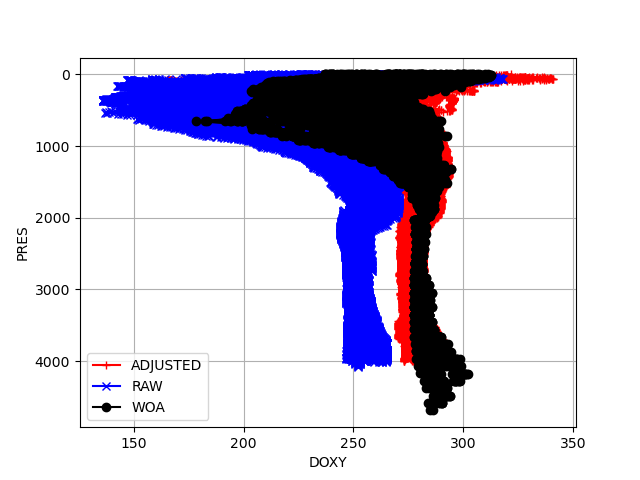

In [38]:
ds_argo_Sprof = corr_data(ds_argo_Sprof,corr_final,launch_date)
_=plot_cmp_corr_oxy_woa(ds_argo_Sprof, ds_woa_interp_on_ARGO)

In [39]:
ds_argo_final = ds_argo_Sprof[['DOXY_ADJUSTED','CYCLE_NUMBER','PRES']]
ds_argo_final.to_netcdf('/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test/corr_python_psatwoaLocodox_' + str(ds_argo_Sprof['PLATFORM_NUMBER'].values[0]) + '.nc')

In [43]:
#
# Gain et Derive final.
#
#gain_final = params_Gain_CTD[0] * params_Gain_Derive_NCEP[0]
#derive_final = params_Gain_Derive_NCEP[1]
coef_pres = params_Gain_Pression[0]
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
comment_corr = 'Adjustement made with NCEP for Gain/Drift + Gain with CTD OVIDE2018 81'
coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, OFFSET=0.000000, DRIFT2=0.000000'
eq_corr = 'PPOX_DOXY = f(DOXY1); PPOX_DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365+DRIFT2/100.*(profile_date_juld-launch_date_juld)**2/365**2)+INCLINE_T*TEMP)*PPOX_DOXY; DOXY_ADJUSTED=f(PPOX_DOXY_ADJUSTED)'
for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    #print(fic_en_cours)
    #print(fic_res)
    if os.path.exists(fic_res):
        os.remove(fic_res)
    corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,gain_final,derive_final,coef_pres)

In [84]:
derive_final

0.49142905130333747